# Reducing the HST tile

Here we show, for one galaxy, our procedure to create cutouts based on the HST image.

1. Load the tile, create mask and weightmap information
2. Estimate the background surface brightness and surface brightness limit $\mu$
3. Create a cutout centered on the galaxy
4. Create a segmentation map, masking other sources
5. Save the segmentation map parameters

***

#### Imports

In [3]:
import sys
sys.path.append('../')

from lib.reduction import *
%load_ext autoreload
%autoreload 2

In [4]:
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.dpi'] = 100
plt.rcParams['patch.antialiased'] = False

## 1. Load the tile

Use `load_raw_data` function to retrieve all the information we need from the FITS file: the image, exposure time map, WCS, PSF, header information, and so on.

Show an example galaxy:

In [3]:
sample = pd.read_csv('../data/catalogs/sample.csv')
galaxy = 'ngc17'
# galaxy = 'ngc1741'
row = sample[sample.galaxy == galaxy].iloc[0]

Load the raw files:

In [18]:
img, mask, chipmask, exptime, psf, header = load_raw_data(row, ignore_ctx=False)

Plot them:

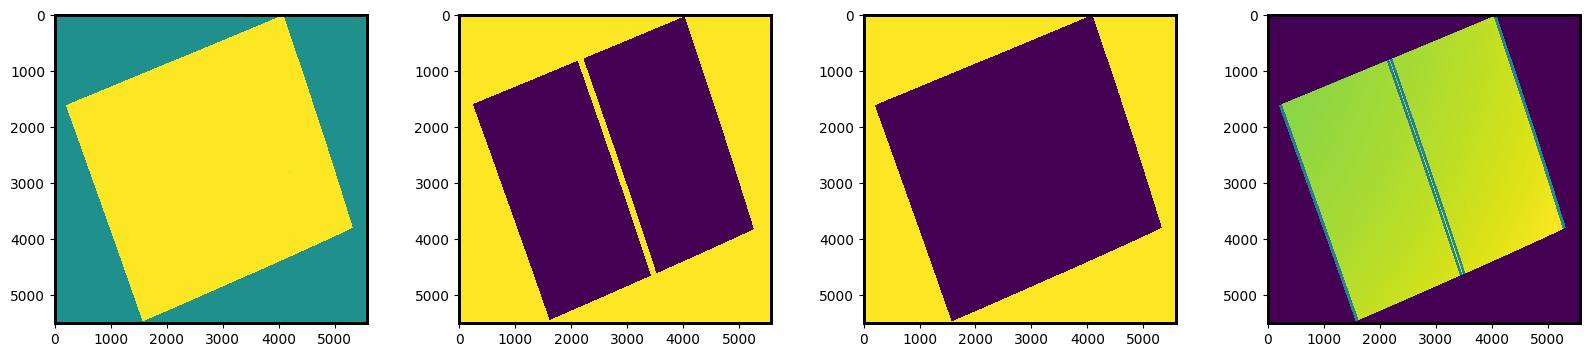

In [19]:
fig, axs = plt.subplots(1, 4, figsize=(20,4))

axs[0].imshow(img, vmin=-0.05, vmax=0.05)
axs[1].imshow(mask, vmin=0)
axs[2].imshow(chipmask, vmax=1)
axs[3].imshow(exptime)

## Estimate the background

Run our iterative background estimation with `estimate_bg`.

1. Smooth the image with a 3x3 Gaussian filter to remove some of the noise
2. Calculate the background RMS with `sigma_clipped_stats`
3. Detect any sources larger than 10px on the convolved image and mask them
4. Repeat until the background RMS converges (max. 30)

Optional step for some images:

5. Fit a 2D background with a 1\% of the image size filter to capture large-scale variability
6. Subtract the background

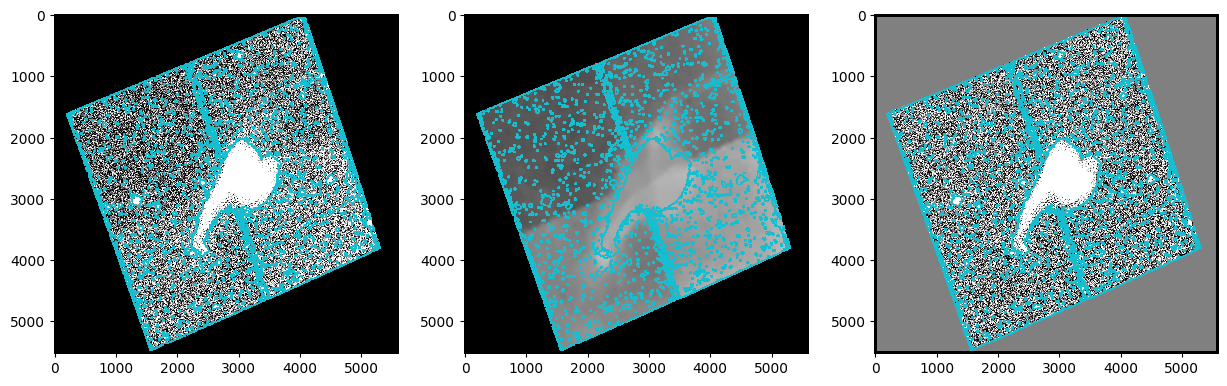

Subtract background? y | n
 y


In [20]:
img_bgsub, bg_med, bg_std, bg_mask, bg_std_map = estimate_bg(img, mask, chipmask, fit_bg=True, filter_size=3)

## Make a cutout & save

Finally save this data to a new FITS file that is used downstream for augmentations -- this is done in `save_cutout`.

In [21]:
mask = mask | chipmask 
save_cutout(row, img_bgsub, exptime, mask, psf, bg_std, bg_std_map, header)

/Users/liza/work/projects/statmorph-lsst/test_suite/nbs/../augmentations.py:234: RuntimeWarning: invalid value encountered in sqrt
  err = np.sqrt(counts)/exp
/Users/liza/work/projects/statmorph-lsst/test_suite/nbs/../augmentations.py:234: RuntimeWarning: invalid value encountered in divide
  err = np.sqrt(counts)/exp


## Load the cutout

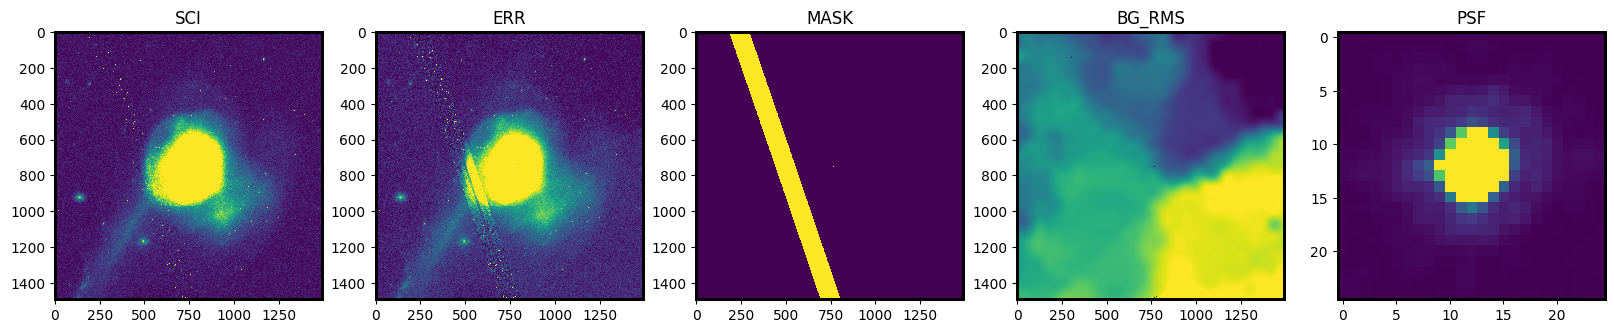

In [22]:
cutout_f = fits.open(f'../data/cutouts/{row.galaxy}.fits')

exts = ['SCI','ERR','MASK','BG_RMS','PSF']
fig, axs = plt.subplots(1, 5, figsize=(20,4))
for ext, ax in zip(exts, axs):
    arr = cutout_f[ext].data
    vmin, vmax = np.nanquantile(arr, q=[0.05, 0.95])
    ax.imshow(arr, vmin=vmin, vmax=vmax)
    ax.set_title(ext)
cutout_f.close()     